Седых Иван Дмитриевич БПМ181

In [1]:
import math

import numpy as np
import sympy as sym
from matplotlib import pyplot as plt
import tqdm
import seaborn as sns


plt.style.use('ggplot')

---
## Task 3

[Threften Bau book](https://mseas.mit.edu/group/References/Books/Trefethen_Bau%20-%20Numerical%20Linear%20Algebra.pdf)  
[code](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)

In [125]:
A = np.array([
    [1, 1],
    [1, 1],
])

A = np.array([
    [0, 2],
    [0, 0],
    [0, 0],
])
A = np.array([
    [3, 0],
    [0, -2],
])

U, s, V = np.linalg.svd(A)
U, np.diag(s), V

(array([[1., 0.],
        [0., 1.]]),
 array([[3., 0.],
        [0., 2.]]),
 array([[ 1.,  0.],
        [-0., -1.]]))

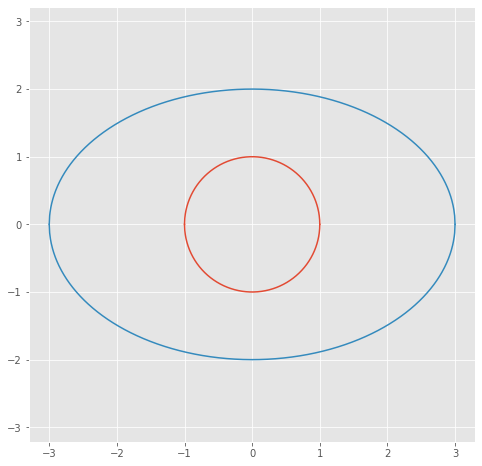

In [129]:
plt.figure(figsize=(8,8))
plt.axis('equal')

x = np.linspace(-1, 1, 1000)
y = np.sqrt(1-(x**2))
plt.plot(x, y, sns.color_palette().as_hex()[0])
plt.plot(x, -y, sns.color_palette().as_hex()[0])
x, y = A @ np.array([x, y])
plt.plot(x, y, sns.color_palette().as_hex()[1])
plt.plot(-x, -y, sns.color_palette().as_hex()[1])
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.show()

---
## Task 5

In [115]:
def woodbury(a, U, V):
    """ (A + UV)^(-1)
    assuming A is diagonal matrix
    A -- n*n
    U -- n*k
    C -- k*k (C=np.eye in this case)
    V -- k*n
    """
    n = A.shape[0]
    k = U.shape[1]
    # storing only diagonal elements (A is diagonal)
    A_inv_diag = 1. / np.diag(A)
    # B is (k*k) matrix so its faster to invert
    B_inv = np.linalg.inv((np.eye(k) + (V * A_inv_diag) @ U))
    res = np.diag(A_inv_diag) - (A_inv_diag.reshape(-1, 1) * U @ B_inv @ V * A_inv_diag)
    return res

In [117]:
# проверили что работает
n_tests = 200
fail_cnt = 0
for test in tqdm.tqdm(range(n_tests)):
    p = np.random.randint(500, 1000)
    k = np.random.randint(10, 250)

    A = np.diag(np.random.randn(p))
    U = np.random.randn(p, k)
    V = np.random.randn(k, p)

    M = A + U @ V
    M_inv_true = np.linalg.inv(M)
    M_inv = woodbury(A, U, V)
    if not np.allclose(M_inv, M_inv_true):
        fail_cnt += 1

print('\n')
print(f"{fail_cnt} fails in {n_tests} tests")

100%|██████████| 200/200 [00:16<00:00, 12.36it/s]

0 fails in 200 tests



In [122]:
%%timeit

p = 5000
k = 100
A = np.diag(np.random.randn(p))
U = np.random.randn(p, k)
V = np.random.randn(k, p)

M = A + U @ V
M_inv_true = np.linalg.inv(M)

5.79 s ± 54.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
%%timeit

p = 5000
k = 100
A = np.diag(np.random.randn(p))
U = np.random.randn(p, k)
V = np.random.randn(k, p)

M_inv = woodbury(A, U, V)

496 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Видим, что мы ускорили работу в 10 раз.**  
Произошло это потому, что обращение матрицы обычно делается за $O(n^3)$, а мы обращали только матрицу размера $k$, который сильно меньше $n$, тем самым получили асимптотику $O(k^3)$.  
Еще я исползовал тот факт, что матрица $A$ - диагональная, что позволяет делать умножения и обращать ее быстрее чем в общем случае.

---
## Task 6 (ODR)

In [125]:
with np.load('data_distance_svd.npz') as data :
    xp, yp, zp = data['xp'], data['yp'], data['zp']

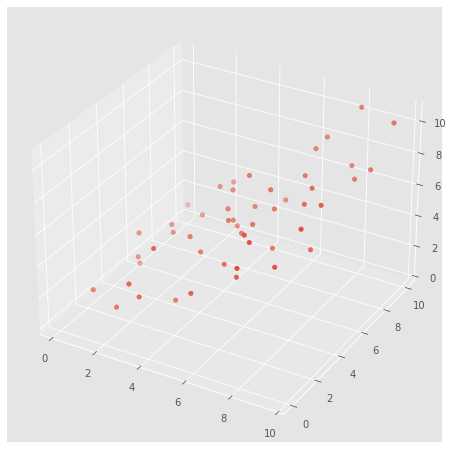

In [131]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xp, yp, zp)

[готовое решение](https://docs.scipy.org/doc/scipy/reference/odr.html)

---
## Task 7 (Прокрустово преобразование)